In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools

from utils.generative import Gaussian
from utils.generative import MixtureDistribution
 
from utils.visualisations import plot_confusion_matrix
from utils.visualisations import plot_weight_matrix

from utils.barycentric import draw_func_contours
from utils.barycentric import get_converging_lines
from utils.barycentric import plot_converging_lines_pvalues

In [2]:
plt.rcParams['figure.figsize'] = (16, 5)

n_samples = 1000

# Square grid precision
grid_levels = 200

# Barycentric grid precision
bc_grid_levels = 50
bc_grid_subdiv = 5

# 1. Mixture of Multivariate Gaussian distribution

prior = 0.33, Distribution = Gaussian(mean = [0 0], cov = [[1 0]
 [0 1]])
prior = 0.33, Distribution = Gaussian(mean = [1 1], cov = [[ 1.  -0.9]
 [-0.9  1. ]])
prior = 0.33, Distribution = Gaussian(mean = [-1  1], cov = [[1.  0.9]
 [0.9 1. ]])



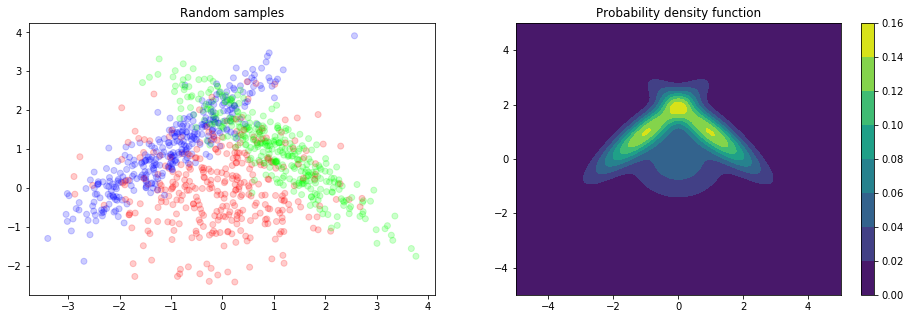

In [3]:
np.random.seed(42)

prior = [1/3, 1/3, 1/3]
a = 1
b = 1
c = 0.9

x_grid = np.linspace(-5, 5, grid_levels)
y_grid = np.linspace(-5, 5, grid_levels)

mg = MixtureDistribution(priors=prior,
                         distributions=[Gaussian([0, 0], [[1, 0], [0, 1]]),
                                        Gaussian([+a, +a], [[+b, -c], [-c, +b]]),
                                        Gaussian([-a, +a], [[+b, +c], [+c, +b]])])

print(mg)

x, y = mg.sample(n_samples)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('Random samples')
ax1.scatter(x[:,0], x[:,1], color=y, alpha=0.2)

xx, yy = np.meshgrid(x_grid, y_grid)
z = mg.pdf(np.vstack([xx.flatten(), yy.flatten()]).T)

ax2 = fig.add_subplot(122)
ax2.set_title('Probability density function')
contour = ax2.contourf(xx, yy, z.reshape(grid_levels,grid_levels))
fig.colorbar(contour)

## 1.a. Individual probability density functions

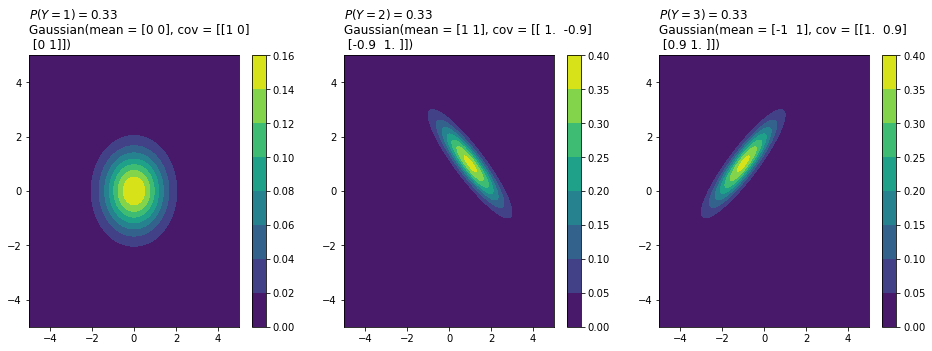

In [4]:
def plot_individual_pdfs(class_dist):
    fig = plt.figure()
    xx, yy = np.meshgrid(x_grid, y_grid)

    for i, (p, d) in enumerate(zip(class_dist.priors, class_dist.distributions)):
        z = d.pdf(np.vstack([xx.flatten(), yy.flatten()]).T)
        
        ax = fig.add_subplot(1, len(class_dist.distributions), i+1)
        ax.set_title('$P(Y={})={:.2f}$\n{}'.format(i+1, p, str(d)), loc='left')
        contour = ax.contourf(xx, yy, z.reshape(grid_levels,grid_levels))
        fig.colorbar(contour)
        
plot_individual_pdfs(mg)

## 1.b. Individual posterior probabilities

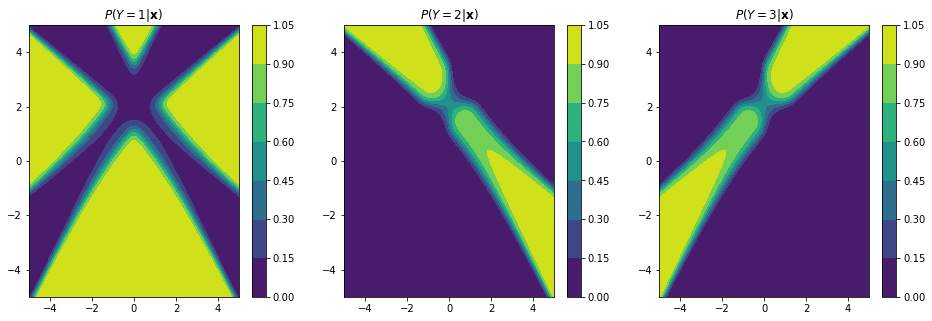

In [5]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = mg.posterior(np.vstack([xx.flatten(), yy.flatten()]).T)
    
for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

# 2. Training a Gaussian Naive Bayes

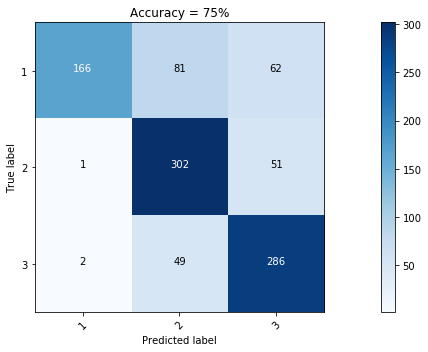

In [6]:
from sklearn.naive_bayes import GaussianNB

x, y_bin = mg.sample(n_samples)
y = np.argmax(y_bin, axis=1)
gnb = GaussianNB()
y_pred = gnb.fit(x, y).predict(x)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)

plot_confusion_matrix(cm, classes=['1', '2', '3'], title="Accuracy = {:.0f}%".format((y == y_pred).mean()*100))

## 2.a. Individual predicted posterior probabilities

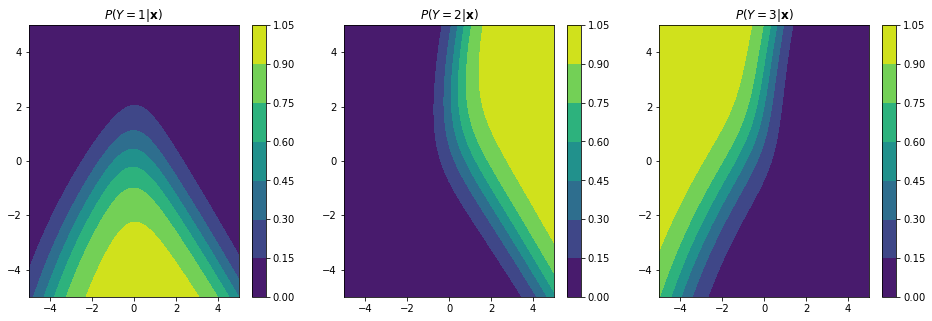

In [7]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = gnb.predict_proba(np.vstack([xx.flatten(), yy.flatten()]).T)

for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

## 2.b. Histogram of predicted probabilities for each Actual class

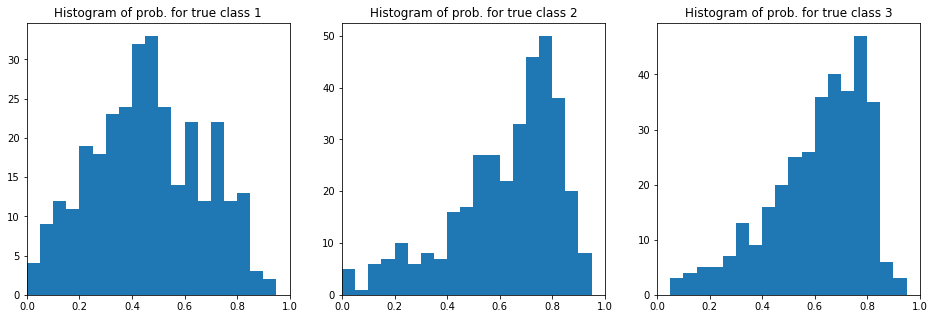

In [15]:
p_pred = gnb.predict_proba(x)

fig = plt.figure()
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('Histogram of prob. for true class {}'.format(i+1))
    ax.hist(p_pred[y == i, i], bins=20, range=(0, 1))
    ax.set_xlim(0, 1)

## 2.c. 2D Histogram of paired predicted probabilities for each Actual class

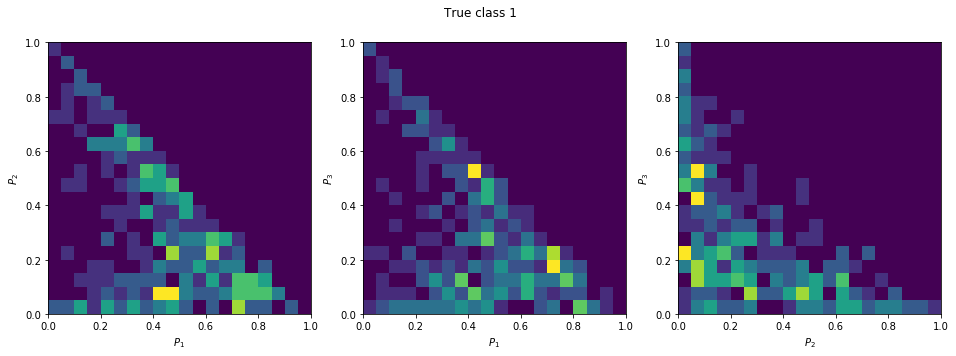

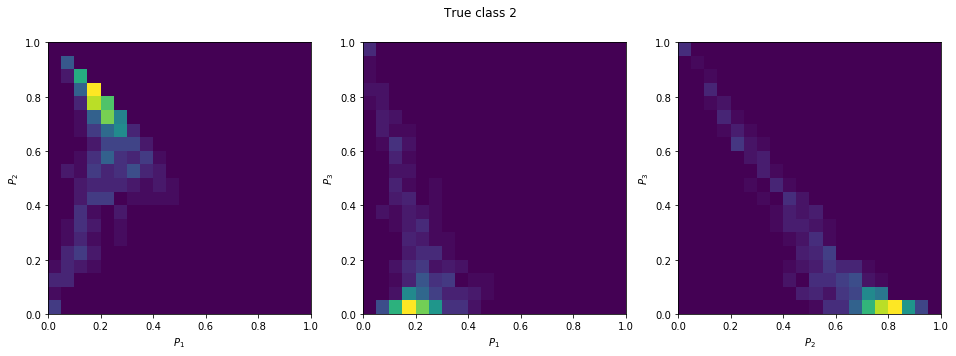

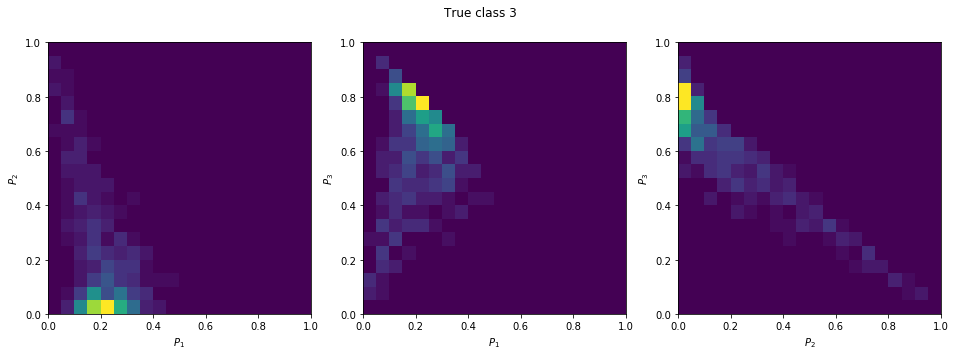

In [16]:
from itertools import combinations

for true_class in [0, 1, 2]:
    fig = plt.figure()
    fig.suptitle('True class {}'.format(true_class+1))
    for i, (cx, cy) in enumerate(combinations([0, 1, 2], 2)):
        ax = fig.add_subplot(1, 3, i+1)
        ax.hist2d(p_pred[y == true_class, cx], p_pred[y == true_class, cy],
                  bins=20, range=[[0, 1], [0, 1]])
        ax.set_xlabel(r'$P_{}$'.format(cx+1))
        ax.set_ylabel(r'$P_{}$'.format(cy+1))

# 3. Calibration with a Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

eps = np.finfo(p_pred.dtype).eps
log_pred = np.log(np.clip(p_pred, eps, 1))

lr = LogisticRegression(C=0.1, solver='lbfgs', multi_class='multinomial').fit(log_pred, y)

cal_pred = lr.predict_proba(log_pred)

y_pred_cal = lr.predict(log_pred)

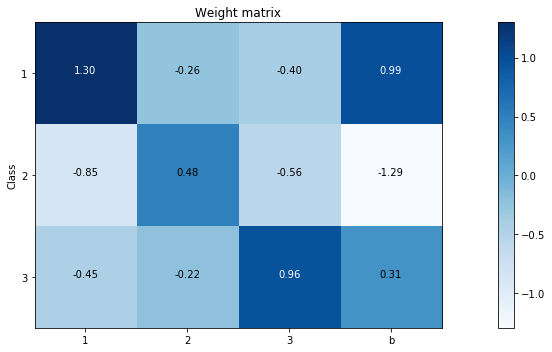

In [22]:
plot_weight_matrix(lr.coef_, lr.intercept_, classes=['1', '2', '3'])

In [23]:
from sklearn.metrics import mean_squared_error

print('Uncalibrated brier score: {}'.format(mean_squared_error(y_bin, p_pred)))
print('Calibrated brier score: {}'.format(mean_squared_error(y_bin, cal_pred)))

Uncalibrated brier score: 0.13253671581987356
Calibrated brier score: 0.12275972980899852


## 3.b. Predicted posteriors

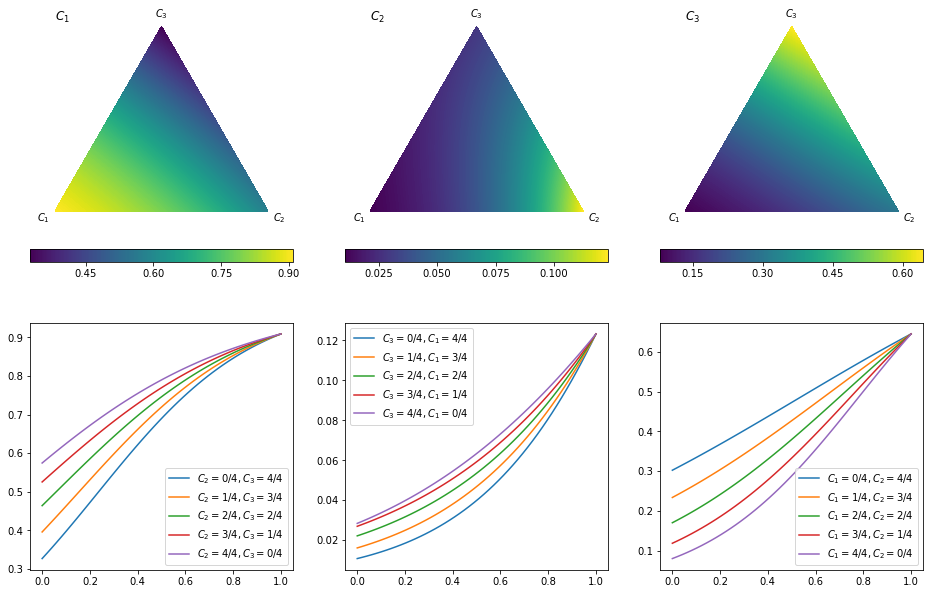

In [25]:
fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)
    
    ax.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: lr.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=bc_grid_levels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)